In [1]:
import numpy as np
import cv2
from skimage import io
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage.feature import hog
import matplotlib.pyplot as plt
from tqdm import tqdm
import pdb
from einops import rearrange
from sklearn.metrics import accuracy_score
# ignore all warning
import warnings
warnings.filterwarnings('ignore')

In [2]:
# customized library
from rcdt_hog_feature_extraction import get_drcdt_feature_sets
from NS_classifier_patch import NS
from utility import get_files_from_folder, get_each_subject_yale_dataset, get_folder_from_path

In [3]:
IMG_EXT = '.pgm' 
INPUT_DATA_PATH = './CroppedYale/'

In [4]:
# perpare to load the data
full_folder = get_folder_from_path(INPUT_DATA_PATH)

In [5]:
# load data and labels
dataX_all_subjects = []
dataY_all_subjects = []

for each_folder_in_full_folder in full_folder:
    path_to_this_folder = INPUT_DATA_PATH + each_folder_in_full_folder + '/'
    imgs_in_this_folder_list = get_files_from_folder(path_to_this_folder, IMG_EXT)
    dataX_this_folder, dataY_this_folder = get_each_subject_yale_dataset(path_to_this_folder, imgs_in_this_folder_list, IMG_EXT, LOG_IMG = False)

    dataX_all_subjects.append(dataX_this_folder)
    dataY_all_subjects.append(dataY_this_folder)

dataX_all_subjects = np.asarray(dataX_all_subjects)
dataY_all_subjects = np.asarray(dataY_all_subjects)




In [6]:
# There 38 subjects
print(dataX_all_subjects.shape)
print(dataY_all_subjects.shape)

(38,)
(38,)


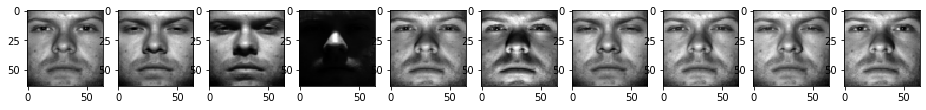

In [7]:
# visulize some face data for sanity check
_, plt_axis_test = plt.subplots(1, 10, figsize=(16,16))
plt_axis_test = plt_axis_test.ravel()

for imyplotN in range(10):
    plt_axis_test[imyplotN].imshow(dataX_all_subjects[0][imyplotN].reshape([64, 64]), cmap='gray')


In [8]:
# Extract D-RCDT feature sets
# setup for the parameters
# training set index is 0
# testing set index is from 1-4
TRAIN_SUBSET = [0] # Training set is 0,
TEST_SUBSET = [4] #  Testing set is 1, 2, 3, 4
STEP_SIZE = 4 # cell size
OVERLAP_SIZE = 1 # overlap size
PROJECT_N = 4 # number of projections
N_SUBJECTS = 38 # number of classes

X_train = []
X_hog_train = []
X_rcdt_train = []
Y_train = []

X_test = []
X_hog_test = []
X_rcdt_test = []
Y_test = []


FEW_SHOT = 1 # 0 -> to use all training samples, 1 -> to only use one training sample

subject_ID = 0
for each_subject_X, each_subject_Y in zip(dataX_all_subjects, dataY_all_subjects):
    #print(each_subject_X.shape, each_subject_Y.shape)
    # get 64 images for each subject and their subset labels
    # build train dataset
    for train_subset_index in TRAIN_SUBSET:
        X_train_each_subject_temp = each_subject_X[each_subject_Y==train_subset_index]
        if FEW_SHOT == 1:
            np.random.seed(1234)
            rand_index = np.random.choice(range(len(X_train_each_subject_temp)), 1, replace=False) # choose one image
            X_train_each_subject_temp = X_train_each_subject_temp[rand_index]

        for X_train_per_img_per_subject in X_train_each_subject_temp:

            _, _, _,rcdt_temp = get_drcdt_feature_sets(X_train_per_img_per_subject.reshape([64,64])*255, step_size=STEP_SIZE, overlap_size = OVERLAP_SIZE, proj_n=PROJECT_N)

            X_train.append(X_train_per_img_per_subject.reshape([64,64]))
            X_rcdt_train.append(rcdt_temp)

            Y_train.append(subject_ID)

    # build testing dataset
    for test_subset_index in TEST_SUBSET:
        X_test_each_subject_temp = each_subject_X[each_subject_Y==test_subset_index]
        for X_test_per_img_per_subject in X_test_each_subject_temp:

            _, _, _, rcdt_temp = get_drcdt_feature_sets(X_test_per_img_per_subject.reshape([64,64])*255, step_size=STEP_SIZE, overlap_size = OVERLAP_SIZE, proj_n=PROJECT_N)
            
            X_test.append(X_test_per_img_per_subject.reshape([64,64]))
            X_rcdt_test.append(rcdt_temp)

            Y_test.append(subject_ID)

    subject_ID = subject_ID + 1


In [9]:
# transform to Numpy asarray
X_train = np.asarray(X_train)
X_hog_train = np.asarray(X_hog_train)
X_rcdt_train = np.asarray(X_rcdt_train)
Y_train = np.asarray(Y_train)

X_test = np.asarray(X_test)
X_hog_test = np.asarray(X_hog_test)
X_rcdt_test = np.asarray(X_rcdt_test)
Y_test = np.asarray(Y_test)

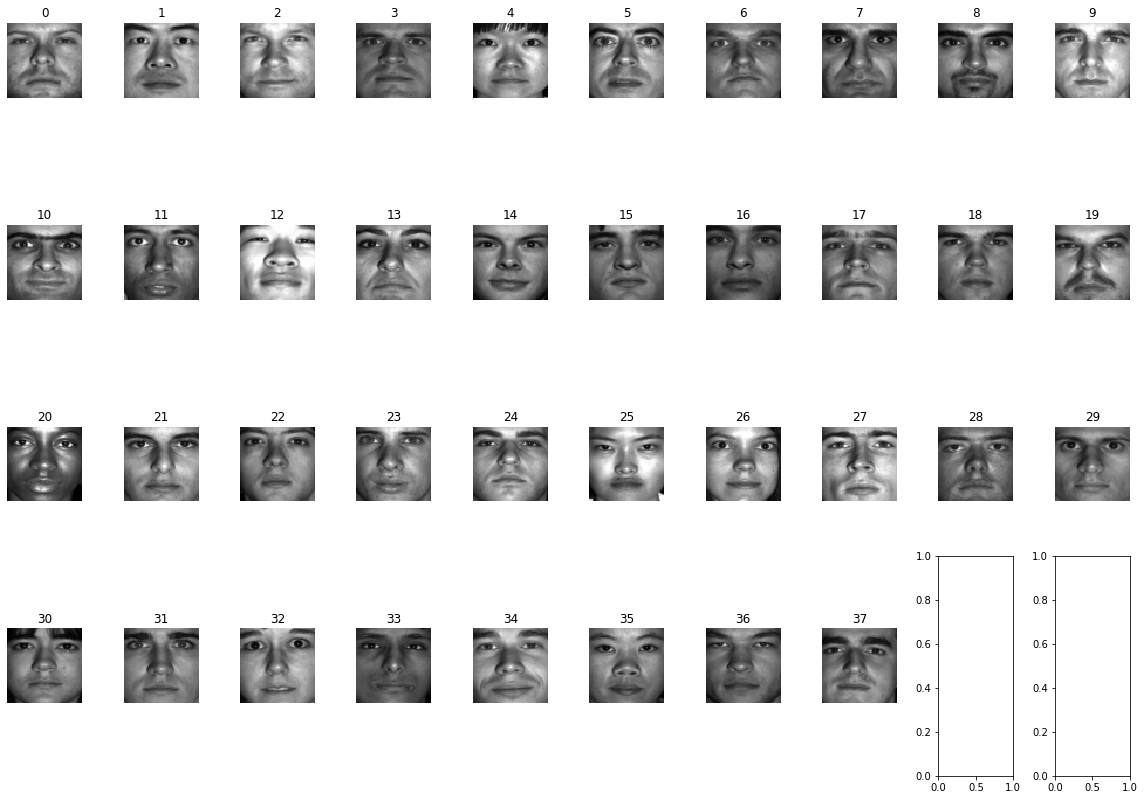

In [10]:
# visualize train samples
if FEW_SHOT == 1:
    fig, ax = plt.subplots(4, 10, figsize=(16,12))
    ax = ax.ravel()
    for i in range(len(X_train)):
        ax[i].imshow(X_train[i], cmap='gray', vmax=1, vmin=0)
        ax[i].set_title(str(Y_train[i]))
        ax[i].axis('off')
    plt.tight_layout()

else:
    fig, ax = plt.subplots(4, 10, figsize=(16,12))
    ax = ax.ravel()
    # plot each subject
    for i in range(N_SUBJECTS):
        pltIndex = np.random.randint(low=0, high=len(Y_train[Y_train == i]), size=1, dtype=int)[0]
        ax[i].imshow(X_train[Y_train == i][pltIndex], cmap='gray', vmax=1, vmin=0)
        ax[i].set_title(str(Y_train[Y_train == i][pltIndex]))
        ax[i].axis('off')
    plt.tight_layout()
    


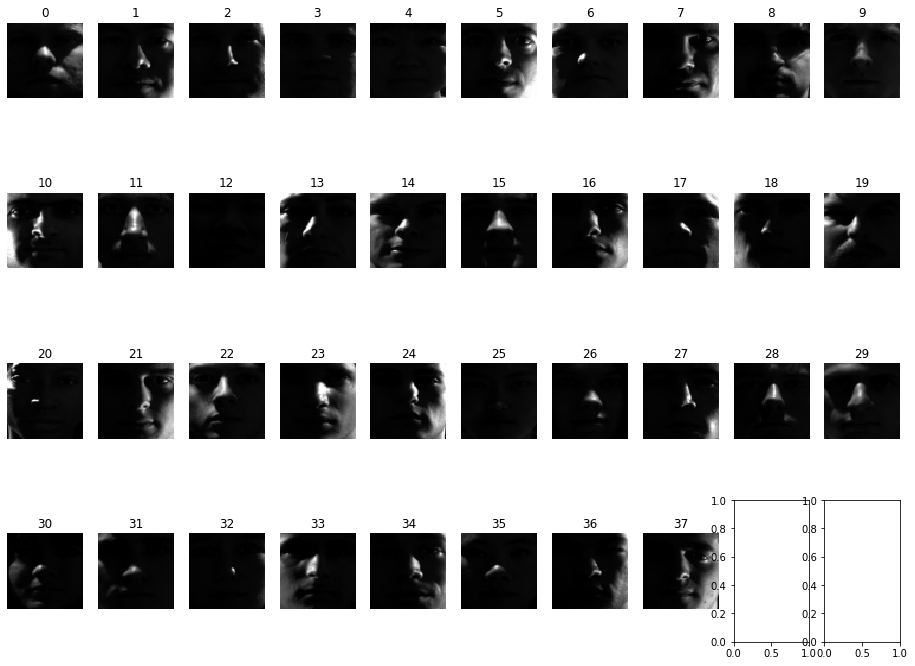

In [11]:
# visualize test samples
fig, ax = plt.subplots(4, 10, figsize=(16,12))
ax = ax.ravel()
# plot each subject
for i in range(38):
    pltIndex = np.random.randint(low=0, high=len(Y_test[Y_test == i]), size=1, dtype=int)[0]
    ax[i].imshow(X_test[Y_test == i][pltIndex], cmap='gray', vmax=1, vmin=0)
    ax[i].set_title(str(Y_test[Y_test == i][pltIndex]))
    ax[i].axis('off')
    #plt.tight_layout()

In [12]:
# show image information, RCDT-HOG information, y label information
print(X_train.shape, X_rcdt_train.shape, Y_train.shape)
print(X_test.shape, X_rcdt_test.shape, Y_test.shape)


(38, 64, 64) (38, 21, 21, 16, 4) (38,)
(490, 64, 64) (490, 21, 21, 16, 4) (490,)


In [13]:
# Perform subspace learning
# training the NS classifiers
NS_clfs = [] # 
ROW_N = X_rcdt_train.shape[1]; COL_N = X_rcdt_train.shape[2]

# if there are multiple traning samples, use cross-validation scheme to choose N_VAR as indicated in the paper
# otherwise choose N_VAR = 0.99
N_VAR = 0.99 if FEW_SHOT == 1 else 0.8

# train NS subspace classifiers seperately
for row_n in range(ROW_N):
    for col_n in range(COL_N):
        #print('row {}, col {}'.format(row_n,col_n))
        X_train_temp = X_rcdt_train[:,row_n,col_n,:,:]
        X_train_temp_new = []
        for X_train_temp_each in X_train_temp:
            X_train_temp_new.append(X_train_temp_each.ravel())
        X_train_temp_new = np.asarray(X_train_temp_new)
        clf_ns = NS(num_classes=N_SUBJECTS, num_proj = PROJECT_N, n_var=N_VAR)
        clf_ns.fit(X_train_temp_new, Y_train) # build V^c_k subspace for k'th Patch
        NS_clfs.append(clf_ns)

In [14]:
# perform testing
subspace_test_NS_output_softmax = np.zeros([len(X_rcdt_test), ROW_N, COL_N, N_SUBJECTS])
subject_cnt = 0
for each_test_subject in X_rcdt_test:
    for row_n in range(ROW_N):
        for col_n in range(COL_N):
            each_test_subject_block = each_test_subject[row_n,col_n,:,:].ravel()
            each_test_subject_block = each_test_subject_block.reshape([1, len(each_test_subject_block)])
            pred_vector_test, pred_test = NS_clfs[row_n*ROW_N+col_n].predict(each_test_subject_block)
            # compute d_k^c 
            subspace_test_NS_output_softmax[subject_cnt, row_n, col_n, : ] = pred_vector_test.ravel()/np.linalg.norm(pred_vector_test.ravel()+1e-5)

    subject_cnt = subject_cnt + 1


print(subspace_test_NS_output_softmax.shape)



(490, 21, 21, 38)


In [15]:
# calculate the classification accuracy
def get_acc(input_vectors_patch, input_y_test):
    # summing the distance contribution d^c_k and search c for the classification result
    # input shape: batch, height, width, features
    input_vectors_patch_new = rearrange(input_vectors_patch, 'b h w f -> b f (h w) ')
    input_vectors_patch_new_aggre = np.sum(input_vectors_patch_new, axis=2)
    y_pred_union = np.argmin(input_vectors_patch_new_aggre, axis=1)

    return accuracy_score(y_pred_union, input_y_test)

print(get_acc(subspace_test_NS_output_softmax, Y_test))

0.9183673469387755
